In [12]:
import networkx as nx
import ndlib.models.epidemics as ep
from bokeh.io import output_notebook, show
from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend
import ndlib.models.ModelConfig as mc
from ndlib.viz.bokeh.MultiPlot import MultiPlot
import matplotlib.pyplot as plt
import numpy as np
import random

In [13]:
# Helper functions

def config_SIR(model, beta, gamma, fraction_infected = 0.01, infect_specific_nodes = False, infected_nodes = []):
    '''Takes the SIR model as input and its parameters
    Configures said model with these parameters.'''
    config = mc.Configuration()
    config.add_model_parameter('beta', beta)
    config.add_model_parameter('gamma', gamma)

    if infect_specific_nodes == True:
        config.add_model_initial_configuration("Infected", infected_nodes)
    else:
        config.add_model_parameter("fraction_infected", fraction_infected)
    model.set_initial_status(config)
    
    
def get_SIR_result_lists(results):
    '''Takes SIR simulation results (model.build_trends(iterations)) as input variable
    Unpacks this variable and outputs S, I, R node count as lists.'''
    S_node_count = results[0]['trends']['node_count'][0]
    I_node_count = results[0]['trends']['node_count'][1]
    R_node_count = results[0]['trends']['node_count'][2]
    return S_node_count, I_node_count, R_node_count


def average_clustering_coef(network, N):
    '''Takes some network G and the number of nodes of the network.
    Calculates the clustering coefficient for every node and returns the average.'''
    cluster_coef_list = list(nx.clustering(network).values())
    avg_clustering_coef = sum(cluster_coef_list)/N
    return avg_clustering_coef

def list_avg(input_list):
    '''calculated the average of a list of numbers'''
    return sum(input_list)/len(input_list)

def average_runs(list_of_run_lists):
    '''Takes a list of lists of timeseries data of the same size.
    Returns one list as a an elementwise mean of all the runs.'''
    array = np.array(list_of_run_lists)
    # Calculate the element-wise mean
    elementwise_mean = np.mean(array, axis=0)
    return elementwise_mean.tolist()

def get_max_degree_nodes(g, no_max_nodes):
    '''Takes a graph g as input and no_max_nodes as number of maximum nodes required.
    Returns indicies of nodes with maximal degree count in the graph. '''
    node_degree_dict = dict(nx.degree(g))
    sorted_dict = {k: v for k, v in sorted(node_degree_dict.items(), key=lambda item: item[1], reverse=True)}
    return list(sorted_dict.keys())[:no_max_nodes]


**Investigate the effect of network parameters on the spread**

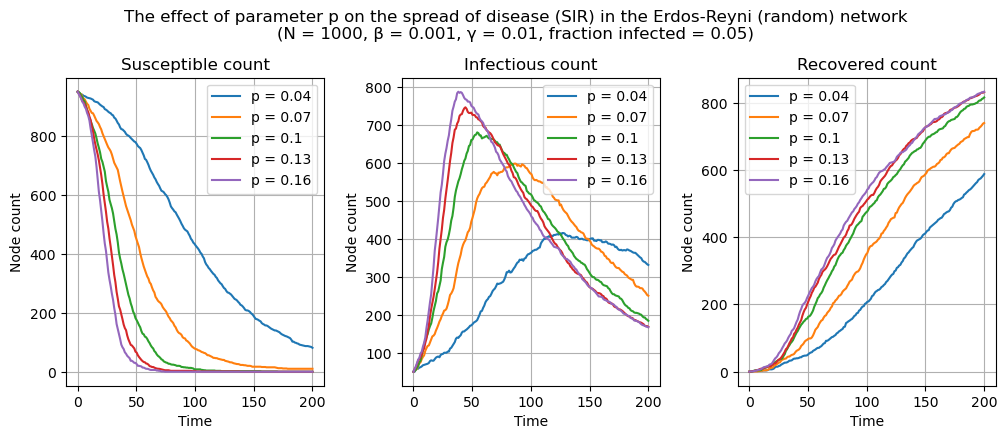

In [14]:
#Simulate Erdos-Reyni (random) network. Investigate the effect of p on the spread of disease (SIR).

p_variations = [0.04, 0.07, 0.1, 0.13, 0.16]
beta = 0.001
gamma = 0.01
fraction_infected = 0.05
time_steps = 200
N = 1000

time = np.linspace(0, time_steps, time_steps)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'wspace': 0.3})

for p in p_variations:
    # Network Definition
    g = nx.erdos_renyi_graph(N, p)
    
    # Import SIR
    model = ep.SIRModel(g)
    
    config_SIR(model, beta, gamma, fraction_infected)

    # Simulation
    iterations = model.iteration_bunch(time_steps)
    trends = model.build_trends(iterations)
    S_node_count, I_node_count, R_node_count = get_SIR_result_lists(trends)
    
    #Plot
    ax1.plot(time, S_node_count, label = f'p = {p}')
    ax1.set_title('Susceptible count')

    ax2.plot(time, I_node_count, label = f'p = {p}')
    ax2.set_title('Infectious count')

    ax3.plot(time, R_node_count, label = f'p = {p}')
    ax3.set_title('Recovered count')
    
    for subfig in [ax1, ax2, ax3]:
        subfig.set_xlabel('Time')
        subfig.set_ylabel('Node count')
        subfig.grid(True)
        subfig.legend()
    
    fig.suptitle(f'The effect of parameter p on the spread of disease (SIR) in the Erdos-Reyni (random) network\n(N = {N}, β = {beta}, γ = {gamma}, fraction infected = {fraction_infected})',  y=1.05)
    
    
    

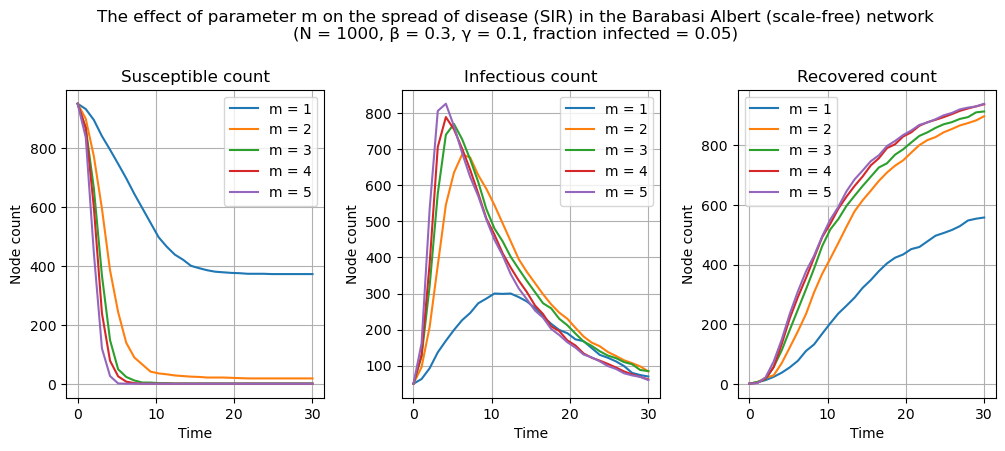

In [15]:
#Simulate Barabasi Albert (scale-free) network. Investigate the effect of m on the spread of disease (SIR).

m_variations = [1, 2, 3, 4, 5]
beta = 0.3
gamma = 0.1
fraction_infected = 0.05
time_steps = 30
N = 1000

time = np.linspace(0, time_steps, time_steps)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'wspace': 0.3})

for m in m_variations:
    # Network Definition
    g = nx.barabasi_albert_graph(N, m)
    
    # Import SIR
    model = ep.SIRModel(g)
    
    config_SIR(model, beta, gamma, fraction_infected)

    # Simulation
    iterations = model.iteration_bunch(time_steps)
    trends = model.build_trends(iterations)
    S_node_count, I_node_count, R_node_count = get_SIR_result_lists(trends)

    #Plot
    ax1.plot(time, S_node_count, label = f'm = {m}')
    ax1.set_title('Susceptible count')

    ax2.plot(time, I_node_count, label = f'm = {m}')
    ax2.set_title('Infectious count')

    ax3.plot(time, R_node_count, label = f'm = {m}')
    ax3.set_title('Recovered count')
    
    for subfig in [ax1, ax2, ax3]:
        subfig.set_xlabel('Time')
        subfig.set_ylabel('Node count')
        subfig.grid(True)
        subfig.legend()
    
    fig.suptitle(f'The effect of parameter m on the spread of disease (SIR) in the Barabasi Albert (scale-free) network\n(N = {N}, β = {beta}, γ = {gamma}, fraction infected = {fraction_infected})',  y=1.08)

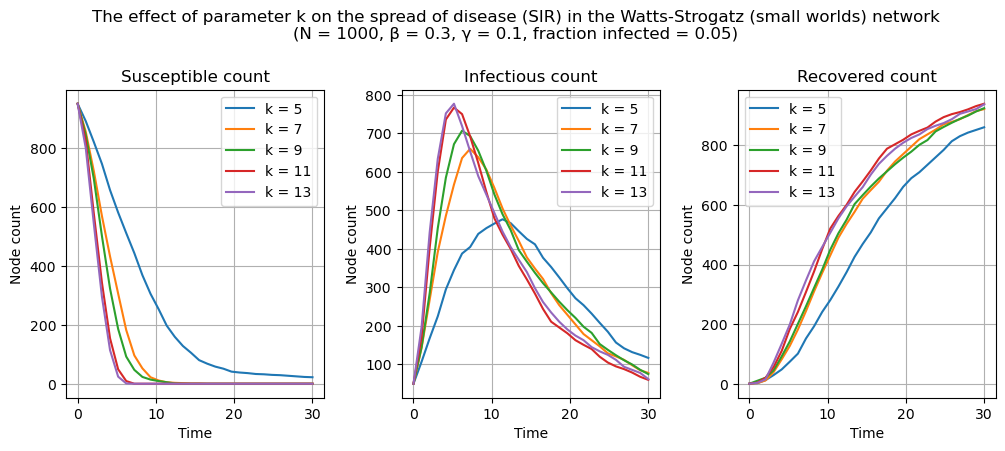

In [17]:
#Simulate Watts-Strogatz (small worlds) network. Investigate the effect of k on the spread of disease (SIR).

k_variations = [5, 7, 9, 11, 13]
prob = 0.05
beta = 0.3
gamma = 0.1
fraction_infected = 0.05
time_steps = 30
N = 1000

time = np.linspace(0, time_steps, time_steps)
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'wspace': 0.3})

for k in k_variations:
    # Network Definition
    g = nx.watts_strogatz_graph(N, k, prob)
    
    # Import SIR
    model = ep.SIRModel(g)
    
    config_SIR(model, beta, gamma, fraction_infected)

    # Simulation
    iterations = model.iteration_bunch(time_steps)
    trends = model.build_trends(iterations)
    S_node_count, I_node_count, R_node_count = get_SIR_result_lists(trends)
    
    #Plot
    ax1.plot(time, S_node_count, label = f'k = {k}')
    ax1.set_title('Susceptible count')

    ax2.plot(time, I_node_count, label = f'k = {k}')
    ax2.set_title('Infectious count')

    ax3.plot(time, R_node_count, label = f'k = {k}')
    ax3.set_title('Recovered count')
    
    for subfig in [ax1, ax2, ax3]:
        subfig.set_xlabel('Time')
        subfig.set_ylabel('Node count')
        subfig.grid(True)
        subfig.legend()
    
    fig1.suptitle(f'The effect of parameter k on the spread of disease (SIR) in the Watts-Strogatz (small worlds) network\n(N = {N}, β = {beta}, γ = {gamma}, fraction infected = {fraction_infected})',  y=1.08)
    
    

#Simulate Watts-Strogatz (small worlds) network. Investigate the effect of p (prob) on the spread of disease (SIR).
k = 5
prob_variations = [0.05, 0.10, 0.15, 0.25]
beta = 0.3
gamma = 0.1
fraction_infected = 0.05
time_steps = 30
N = 1000

time = np.linspace(0, time_steps, time_steps)
fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'wspace': 0.3})

for prob in prob_variations:
    # Network Definition
    g = nx.watts_strogatz_graph(N, k, prob)
    
    # Import SIR
    model = ep.SIRModel(g)
    
    config_SIR(model, beta, gamma, fraction_infected)

    # Simulation
    iterations = model.iteration_bunch(time_steps)
    trends = model.build_trends(iterations)
    S_node_count, I_node_count, R_node_count = get_SIR_result_lists(trends)
    
    #Plot
    ax1.plot(time, S_node_count, label = f'p = {prob}')
    ax1.set_title('Susceptible count')

    ax2.plot(time, I_node_count, label = f'p = {prob}')
    ax2.set_title('Infectious count')

    ax3.plot(time, R_node_count, label = f'p = {prob}')
    ax3.set_title('Recovered count')
    
    for subfig in [ax1, ax2, ax3]:
        subfig.set_xlabel('Time')
        subfig.set_ylabel('Node count')
        subfig.grid(True)
        subfig.legend()
    
    fig2.suptitle(f'The effect of parameter p on the spread of disease (SIR) in the Watts-Strogatz (small worlds) network\n(N = {N}, β = {beta}, γ = {gamma}, fraction infected = {fraction_infected})',  y=1.08)

In [18]:
# nx.graph_edit_distance(BA, WS) #too computationally expensive, breaks the kernel

**Generate Networks of equivalent form**

In [19]:
#Finding networks of equivalent form: We control for N and number of edges

N = 1000
#adjust network parameters
p_ER = 0.04
m_BA = 20
k_WS = 40
p_WS = 0.2
plt.figure(figsize=(10, 6))

ER_edge_num = []
BA_edge_num = []
WS_edge_num = []

for i in range(10):
    #Erdos-Reyni (random) network
    ER = nx.erdos_renyi_graph(N, p_ER, seed=i)           #use seeds 0 to 10
    ER_edge_num.append(nx.number_of_edges(ER))

    #Simulate Barabasi Albert (scale-free) network
    BA = nx.barabasi_albert_graph(N, m_BA, seed=i)          #use seeds 0 to 10
    BA_edge_num.append(nx.number_of_edges(BA))

    #Watts-Strogatz (small worlds) network
    WS = nx.watts_strogatz_graph(N, k_WS, p_WS, seed=i)    #use seeds 0 to 10
    WS_edge_num.append(nx.number_of_edges(WS))

print(list_avg(ER_edge_num))
print(list_avg(BA_edge_num))
print(list_avg(WS_edge_num))

19942.4
19600.0
20000.0


<Figure size 1000x600 with 0 Axes>

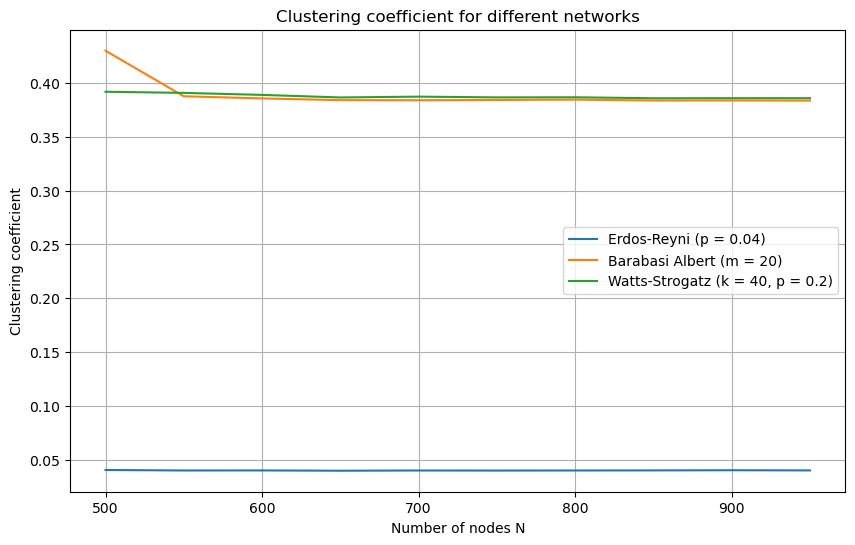

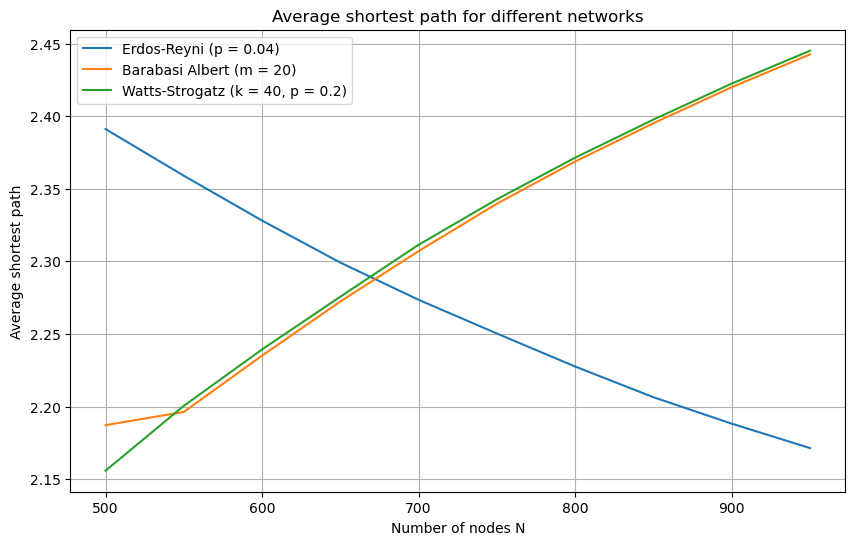

In [20]:
#Plotting Network statistics against N

N_variations = range(500, 1000, 50)
#adjust network parameters
p_ER = 0.04
m_BA = 20
k_WS = 40
p_WS = 0.2

ER_clust_coef = []
BA_clust_coef = []
WS_clust_coef = []

ER_avg_shortest_path = []
BA_avg_shortest_path = []
WS_avg_shortest_path = []

for N in N_variations:
    all_runs_clust_coef_ER = []
    all_runs_shortest_path_ER = []
    all_runs_clust_coef_BA = []
    all_runs_shortest_path_BA = []
    all_runs_clust_coef_WS = []
    all_runs_shortest_path_WS = []

    #10 experiments for each network
    for i in range(10):
        #Erdos-Reyni (random) network
        ER = nx.erdos_renyi_graph(N, p_ER, seed = i)                       #use seeds 0 to 10        
        all_runs_clust_coef_ER.append(average_clustering_coef(ER, N))
        all_runs_shortest_path_ER.append(nx.average_shortest_path_length(ER))

        #Simulate Barabasi Albert (scale-free) network
        BA = nx.barabasi_albert_graph(N, m_BA, seed = i)                      #use seeds 0 to 10
        all_runs_clust_coef_BA.append(average_clustering_coef(WS, N))
        all_runs_shortest_path_BA.append(nx.average_shortest_path_length(WS))
        
        #Watts-Strogatz (small worlds) network
        WS = nx.watts_strogatz_graph(N, k_WS, p_WS, seed = i)                #use seeds 0 to 10
        all_runs_clust_coef_WS.append(average_clustering_coef(WS, N))
        all_runs_shortest_path_WS.append(nx.average_shortest_path_length(WS))

    #add averages of all runs for clustering coef and shortest path accordingly
    ER_clust_coef.append(list_avg(all_runs_clust_coef_ER))
    ER_avg_shortest_path.append(list_avg(all_runs_shortest_path_ER))
    BA_clust_coef.append(list_avg(all_runs_clust_coef_BA))
    BA_avg_shortest_path.append(list_avg(all_runs_shortest_path_BA))
    WS_clust_coef.append(list_avg(all_runs_clust_coef_WS))
    WS_avg_shortest_path.append(list_avg(all_runs_shortest_path_WS))


#Plot
plt.figure(figsize=(10, 6))
plt.plot(N_variations, ER_clust_coef, label = f'Erdos-Reyni (p = {p_ER})')
plt.plot(N_variations, BA_clust_coef, label = f'Barabasi Albert (m = {m_BA})')
plt.plot(N_variations, WS_clust_coef, label = f'Watts-Strogatz (k = {k_WS}, p = {p_WS})')
plt.xlabel('Number of nodes N')
plt.ylabel('Clustering coefficient')
plt.title('Clustering coefficient for different networks')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(N_variations, ER_avg_shortest_path, label = f'Erdos-Reyni (p = {p_ER})')
plt.plot(N_variations, BA_avg_shortest_path, label = f'Barabasi Albert (m = {m_BA})')
plt.plot(N_variations, WS_avg_shortest_path, label = f'Watts-Strogatz (k = {k_WS}, p = {p_WS})')
plt.xlabel('Number of nodes N')
plt.ylabel('Average shortest path')
plt.title('Average shortest path for different networks')
plt.legend()
plt.grid(True)
plt.show()



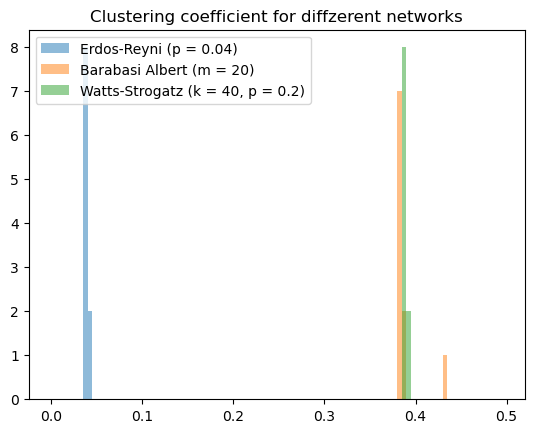

In [23]:
#Create histograms for above plots (network statistics)
bins_clust_coef = [x/1000 for x in range(0, 500, 5)]
plt.hist(ER_clust_coef, bins = bins_clust_coef, alpha=0.5, label = f'Erdos-Reyni (p = {p_ER})')
plt.hist(BA_clust_coef, bins = bins_clust_coef, alpha=0.5, label = f'Barabasi Albert (m = {m_BA})')
plt.hist(WS_clust_coef, bins = bins_clust_coef, alpha=0.5, label = f'Watts-Strogatz (k = {k_WS}, p = {p_WS})')
plt.title('Clustering coefficient for diffzerent networks')
plt.legend()
plt.show()

bins_avg_shortest_path = [x/100 for x in range(200, 250, 10)]
plt.hist(ER_avg_shortest_path, bins = bins_avg_shortest_path, alpha=0.5, label = f'Erdos-Reyni (p = {p_ER})')
plt.hist(BA_avg_shortest_path, bins = bins_avg_shortest_path, alpha=0.5, label = f'Barabasi Albert (m = {m_BA})')
plt.hist(WS_avg_shortest_path, bins = bins_avg_shortest_path, alpha=0.5, label = f'Watts-Strogatz (k = {k_WS}, p = {p_WS})')
plt.title('Average shortest distance for different networks')
plt.legend()
plt.show()

**Simulate SIR spread on the network**

Text(0.5, 1.05, 'SIR spread for different networks (N = 1000, β = 0.01, γ = 0.009, fraction infected = 0.05)')

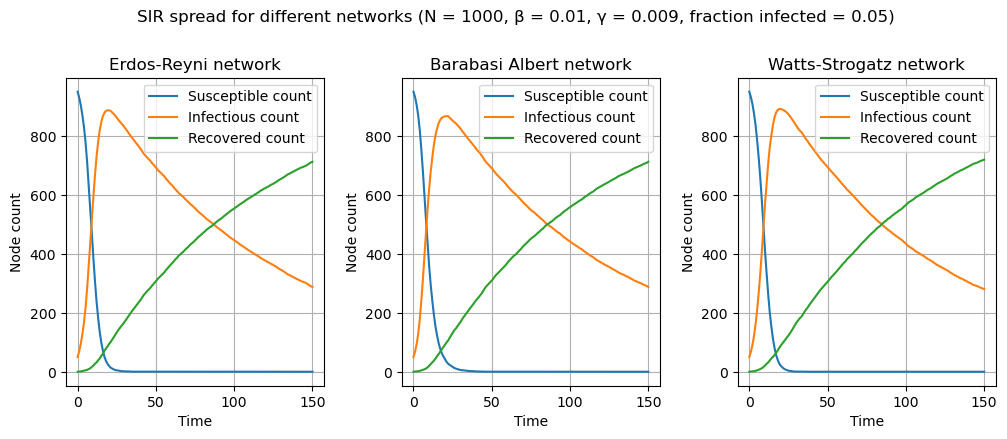

In [10]:
#Network parameters (set from before, controlled for similarity)
N = 1000
p_ER = 0.04
m_BA = 20
k_WS = 40
p_WS = 0.2

#SIR parameters
beta = 0.01
gamma = 0.009
fraction_infected = 0.05
time_steps = 150

time = np.linspace(0, time_steps, time_steps)

network_names = ['Erdos-Reyni', 'Barabasi Albert', 'Watts-Strogatz']

fig, ax = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'wspace': 0.3})

#Simulate spread
for i in range(len(network_names)):
    #initialize storing run data
    S_runs = []
    I_runs = []
    R_runs = []

    for seed in range(0, 10):
        #define network
        if network_names[i] == 'Erdos-Reyni':
            ER = nx.erdos_renyi_graph(N, p_ER, seed = seed)
            model = ep.SIRModel(ER)
            
        elif network_names[i] == 'Barabasi Albert':
            BA = nx.barabasi_albert_graph(N, m_BA, seed = seed) 
            model = ep.SIRModel(BA) 
        else:
            WS = nx.watts_strogatz_graph(N, k_WS, p_WS, seed = seed)
            model = ep.SIRModel(WS) 

        
        config_SIR(model, beta, gamma, fraction_infected)

        # Simulation
        iterations = model.iteration_bunch(time_steps)
        trends = model.build_trends(iterations)
        S_node_count, I_node_count, R_node_count = get_SIR_result_lists(trends)
        # Add run data to the pre-allocated list
        S_runs.append(S_node_count)
        I_runs.append(I_node_count)
        R_runs.append(R_node_count)

    #compute element-wise average across runs

    avg_S = average_runs(S_runs)
    avg_I = average_runs(I_runs)
    avg_R = average_runs(R_runs)

    #Plot
    ax[i].plot(time, avg_S, label = 'Susceptible count')
    ax[i].plot(time, avg_I, label = 'Infectious count')
    ax[i].plot(time, avg_R, label = 'Recovered count')
    ax[i].set_title(f'{network_names[i]} network')
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Node count')
    ax[i].grid(True)
    ax[i].legend(loc = 'upper right')
    
fig.suptitle(f'SIR spread for different networks (N = {N}, β = {beta}, γ = {gamma}, fraction infected = {fraction_infected})',  y=1.05)
#NOTE: add network parameters in the caption of the figure in the report

Text(0.5, 1.05, 'Effect of varying initial proportion of infected individuals on\nSIR spread for different networks (N = 1000, β = 0.01, γ = 0.009)')

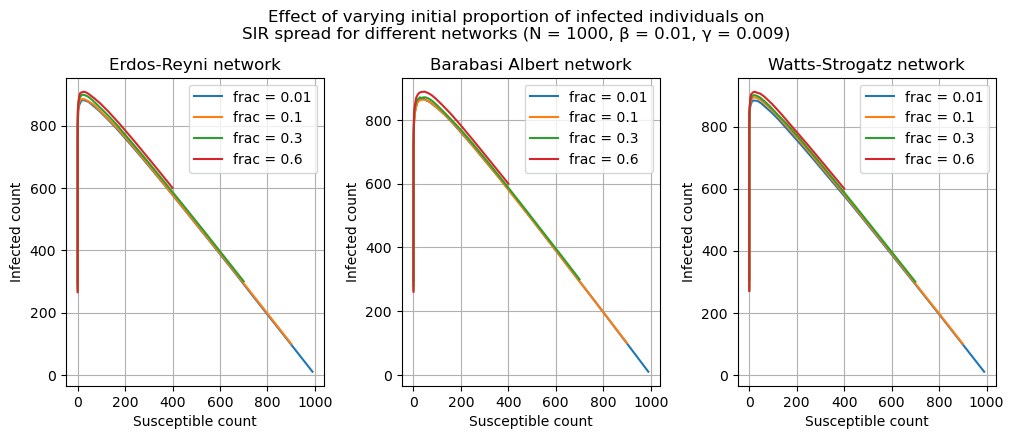

In [24]:
#Vary fraction of infected across different networks
#Network parameters (set from before, controlled for similarity)
N = 1000
p_ER = 0.04
m_BA = 20
k_WS = 40
p_WS = 0.2

#SIR parameters
beta = 0.01
gamma = 0.009
fraction_infected_vars = [0.01, 0.1, 0.3, 0.6]
time_steps = 150

time = np.linspace(0, time_steps, time_steps)

network_names = ['Erdos-Reyni', 'Barabasi Albert', 'Watts-Strogatz']

fig, ax = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'wspace': 0.3})

#Simulate spread
for i in range(len(network_names)):
    for fraction_infected in fraction_infected_vars:
        #initialize storing run data
        S_runs = []
        I_runs = []

        for seed in range(0, 10):
            #define network
            if network_names[i] == 'Erdos-Reyni':
                ER = nx.erdos_renyi_graph(N, p_ER, seed = seed)
                model = ep.SIRModel(ER)
            elif network_names[i] == 'Barabasi Albert':
                BA = nx.barabasi_albert_graph(N, m_BA, seed = seed)  
                model = ep.SIRModel(BA)
            else:
                WS = nx.watts_strogatz_graph(N, k_WS, p_WS, seed = seed)
                model = ep.SIRModel(WS)
            
            config_SIR(model, beta, gamma, fraction_infected)

            # Simulation
            iterations = model.iteration_bunch(time_steps)
            trends = model.build_trends(iterations)
            S_node_count, I_node_count, R_node_count = get_SIR_result_lists(trends)
            # Add run data to the pre-allocated list
            S_runs.append(S_node_count)
            I_runs.append(I_node_count)

        #compute element-wise average across runs

        avg_S = average_runs(S_runs)
        avg_I = average_runs(I_runs)

        #Plot
        ax[i].plot(avg_S, avg_I, label = f'frac = {fraction_infected}')
        ax[i].set_title(f'{network_names[i]} network')
        ax[i].set_xlabel('Susceptible count')
        ax[i].set_ylabel('Infected count')
        ax[i].grid(True)
        ax[i].legend(loc = 'upper right')
    
fig.suptitle(f'Effect of varying initial proportion of infected individuals on\nSIR spread for different networks (N = {N}, β = {beta}, γ = {gamma})',  y=1.05)
#NOTE: add network parameters in the caption of the figure in the report

In [28]:
#Infect some nodes with highest degree. Vary the number of these "hubs" attacked

#Network parameters (set from before, controlled for similarity)
N = 1000
p_ER = 0.04
m_BA = 20
k_WS = 40
p_WS = 0.2

#SIR parameters
beta = 0.01
gamma = 0.009
time_steps = 150
attacked_hub_no = [10, 50, 100]

time = np.linspace(0, time_steps, time_steps)

network_names = ['Erdos-Reyni', 'Barabasi Albert', 'Watts-Strogatz']

fig, ax = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'wspace': 0.3})

#Simulate spread
for i in range(len(network_names)):
    for hub_no in attacked_hub_no:
        #initialize storing run data
        S_runs = []
        I_runs = []

        for seed in range(0, 10):
            #define network
            if network_names[i] == 'Erdos-Reyni':
                ER = nx.erdos_renyi_graph(N, p_ER, seed = seed)
                hubs = get_max_degree_nodes(ER, hub_no)
                model = ep.SIRModel(ER)
            elif network_names[i] == 'Barabasi Albert':
                BA = nx.barabasi_albert_graph(N, m_BA, seed = seed)
                hubs = get_max_degree_nodes(BA, hub_no)
                model = ep.SIRModel(BA)  
            else:
                WS = nx.watts_strogatz_graph(N, k_WS, p_WS, seed = seed)
                hubs = get_max_degree_nodes(WS, hub_no)
                model = ep.SIRModel(WS)
            
            config_SIR(model, beta, gamma, infect_specific_nodes = True, infected_nodes = hubs)

            # Simulation
            iterations = model.iteration_bunch(time_steps)
            trends = model.build_trends(iterations)
            S_node_count, I_node_count, R_node_count = get_SIR_result_lists(trends)
            # Add run data to the pre-allocated list
            S_runs.append(S_node_count)
            I_runs.append(I_node_count)

        #compute element-wise average across runs

        avg_S = average_runs(S_runs)
        avg_I = average_runs(I_runs)

        #Plot
        ax[i].plot(avg_S, avg_I, label = f'Hubs attacked = {hub_no}')
        ax[i].set_title(f'{network_names[i]} network')
        ax[i].set_xlabel('Susceptible count')
        ax[i].set_ylabel('Infected count')
        ax[i].grid(True)
        ax[i].legend(loc = 'lower left')
    
fig.suptitle(f'SIR spread for different networks: infecting hubs of different sizes (N = {N}, β = {beta}, γ = {gamma})',  y=1.05)
#NOTE: add network parameters in the caption of the figure in the report

Text(0.5, 1.05, 'SIR spread for different networks: infecting hubs of different sizes (N = 1000, β = 0.01, γ = 0.009)')

Text(0.5, 1.05, 'SIR spread for different networks: infecting random nodes vs. infecting nodes with highest degrees (N = 1000, β = 0.01, γ = 0.009)')

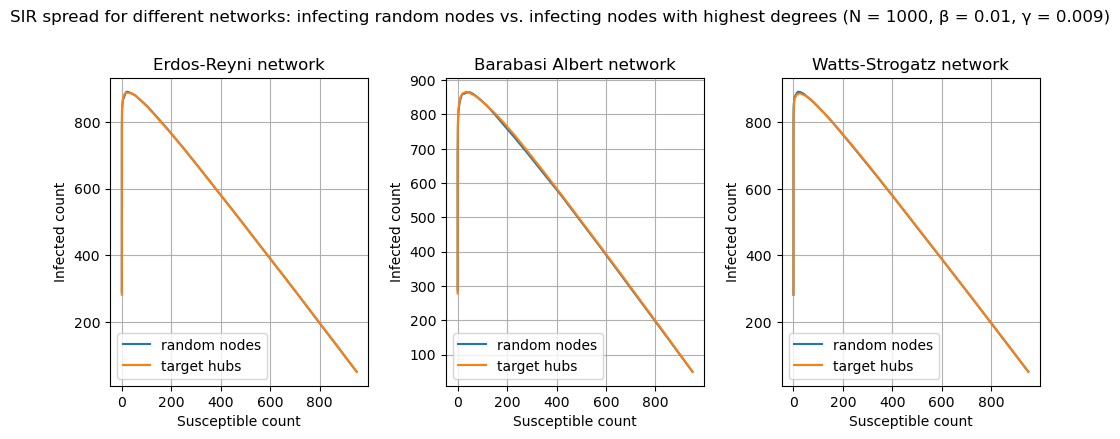

In [26]:
#Compare infecting X random nodes vs. infect X nodes with highest degree

#Network parameters (set from before, controlled for similarity)
N = 1000
p_ER = 0.04
m_BA = 20
k_WS = 40
p_WS = 0.2

#SIR parameters
beta = 0.01
gamma = 0.009
time_steps = 150
no_attacked_nodes = 50
infection_allocation = ['random nodes', 'target hubs']

time = np.linspace(0, time_steps, time_steps)

network_names = ['Erdos-Reyni', 'Barabasi Albert', 'Watts-Strogatz']

fig, ax = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'wspace': 0.3})

#Simulate spread
for i in range(len(network_names)):
    for mode in infection_allocation:
        #initialize storing run data
        S_runs = []
        I_runs = []

        for seed in range(0, 10):
            #define network
            if network_names[i] == 'Erdos-Reyni':
                ER = nx.erdos_renyi_graph(N, p_ER, seed = seed)
                infected_nodes = get_max_degree_nodes(ER, no_attacked_nodes)
                model = ep.SIRModel(ER)
            elif network_names[i] == 'Barabasi Albert':
                BA = nx.barabasi_albert_graph(N, m_BA, seed = seed)
                infected_nodes = get_max_degree_nodes(BA, no_attacked_nodes) 
                model = ep.SIRModel(BA) 
            else:
                WS = nx.watts_strogatz_graph(N, k_WS, p_WS, seed = seed)
                infected_nodes = get_max_degree_nodes(WS, no_attacked_nodes)
                model = ep.SIRModel(WS)

            if mode == 'random nodes':
                infected_nodes = random.sample(range(0, N-1), no_attacked_nodes)

            
            
            config_SIR(model, beta, gamma, infect_specific_nodes = True, infected_nodes = infected_nodes)

            # Simulation
            iterations = model.iteration_bunch(time_steps)
            trends = model.build_trends(iterations)
            S_node_count, I_node_count, R_node_count = get_SIR_result_lists(trends)
            # Add run data to the pre-allocated list
            S_runs.append(S_node_count)
            I_runs.append(I_node_count)

        #compute element-wise average across runs

        avg_S = average_runs(S_runs)
        avg_I = average_runs(I_runs)

        #Plot
        ax[i].plot(avg_S, avg_I, label = f'{mode}')
        ax[i].set_title(f'{network_names[i]} network')
        ax[i].set_xlabel('Susceptible count')
        ax[i].set_ylabel('Infected count')
        ax[i].grid(True)
        ax[i].legend(loc = 'lower left')
    
fig.suptitle(f'SIR spread for different networks: infecting random nodes vs. infecting nodes with highest degrees (N = {N}, β = {beta}, γ = {gamma})',  y=1.05)
#NOTE: add network parameters in the caption of the figure in the report

Text(0.5, 1.05, 'SIR spread for different networks when targeting 50 hubs (N = 1000, β = 0.01, γ = 0.009)')

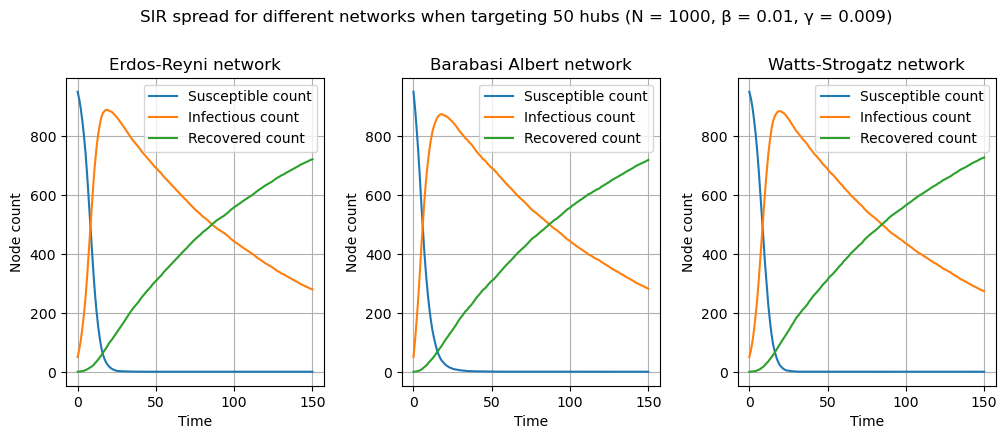

In [27]:
#Look at the actual SIR pattern when attacking the hubs
#Network parameters (set from before, controlled for similarity)
N = 1000
p_ER = 0.04
m_BA = 20
k_WS = 40
p_WS = 0.2

#SIR parameters
beta = 0.01
gamma = 0.009
time_steps = 150
hub_no = 50

time = np.linspace(0, time_steps, time_steps)

network_names = ['Erdos-Reyni', 'Barabasi Albert', 'Watts-Strogatz']

fig, ax = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw={'wspace': 0.3})

#Simulate spread
for i in range(len(network_names)):
    #initialize storing run data
    S_runs = []
    I_runs = []
    R_runs = []

    for seed in range(0, 10):
        #define network
        if network_names[i] == 'Erdos-Reyni':
            ER = nx.erdos_renyi_graph(N, p_ER, seed = seed)
            hubs = get_max_degree_nodes(ER, hub_no)
            model = ep.SIRModel(ER)
        elif network_names[i] == 'Barabasi Albert':
            BA = nx.barabasi_albert_graph(N, m_BA, seed = seed)
            hubs = get_max_degree_nodes(BA, hub_no)
            model = ep.SIRModel(BA)
        else:
            WS = nx.watts_strogatz_graph(N, k_WS, p_WS, seed = seed)
            hubs = get_max_degree_nodes(WS, hub_no)
            model = ep.SIRModel(WS)        
        
        config_SIR(model, beta, gamma, infect_specific_nodes = True, infected_nodes = hubs)

        # Simulation
        iterations = model.iteration_bunch(time_steps)
        trends = model.build_trends(iterations)
        S_node_count, I_node_count, R_node_count = get_SIR_result_lists(trends)
        # Add run data to the pre-allocated list
        S_runs.append(S_node_count)
        I_runs.append(I_node_count)
        R_runs.append(R_node_count)

    #compute element-wise average across runs

    avg_S = average_runs(S_runs)
    avg_I = average_runs(I_runs)
    avg_R = average_runs(R_runs)

    #Plot
    ax[i].plot(time, avg_S, label = 'Susceptible count')
    ax[i].plot(time, avg_I, label = 'Infectious count')
    ax[i].plot(time, avg_R, label = 'Recovered count')
    ax[i].set_title(f'{network_names[i]} network')
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Node count')
    ax[i].grid(True)
    ax[i].legend(loc = 'upper right')
    
fig.suptitle(f'SIR spread for different networks when targeting {hub_no} hubs (N = {N}, β = {beta}, γ = {gamma})',  y=1.05)
#NOTE: add network parameters in the caption of the figure in the report